# Experiments using TO2 wedges

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats.mstats import gmean
from skimage.exposure import rescale_intensity

from mriqa.phantoms import find_phantom, TO2
from mriqa.dcmio import fetch_series, num_frames, pix_spacing_yx, slice_thickness, rx_coil_name, series_number

from mriqa.reports import _get_rect_roi_coords

We'll assume the wedge angle is the same as the plate one, and use a high resolution scan at 3mm slice thickness.
The wedge profiles are differentiated to get the corresponding slice profile.

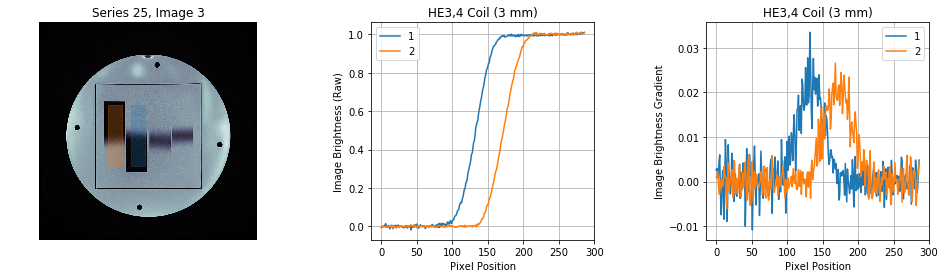

In [2]:
phantom = TO2
phantom['FeatureAxes']['Wedges'] = 0
phantom['FeatureAngles']['Wedges'] = 11.7

# TO2: Slice 3mm
patid = 'PQA20180130RHD'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 1024*1024
dobjs = fetch_series(patid, stuid, sernos=[25])
slice_idx = 2
dobj = dobjs[slice_idx]

image = dobj.pixel_array & 0xfff
pixel_spacing = pix_spacing_yx(dobj)
slice_thick = slice_thickness(dobj)
coil_name = rx_coil_name(dobj)

wedge_angle = phantom['FeatureAngles']['Wedges']

# Positions of wedges
wedges = phantom['Features']['Wedges']
axis = phantom['FeatureAxes']['Wedges']
image = rescale_intensity(image)
pix_dims = np.asarray(pixel_spacing)

assert np.allclose(pix_dims[0], pix_dims[1])

# Centre phantom
expected_radius = phantom['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)
centre = centre_x, centre_y

# Positions of wedges
wedges = phantom['Features']['Wedges']

# Plotting area
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.subplots_adjust(wspace=0.5)

# Phantom image
axes[0].imshow(image, cmap='bone')
axes[0].axis('off')
axes[0].axis('image')

# Thick profile through first inclined plate
x, y, dx, dy = _get_rect_roi_coords(pix_dims, rect=wedges[0], centre=centre)
profile_1 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

# normalise profiles
high_1 = np.mean(profile_1[:50])
low_1 = np.mean(profile_1[-50:])
profile_1 -= low_1
profile_1 /= (high_1 - low_1)
profile_1 = 1- profile_1

# Show profiles on phantom
axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color='C0', alpha=0.25))

# Thick profile through second inclined plate
x, y, dx, dy = _get_rect_roi_coords(pix_dims, rect=wedges[1], centre=centre)
profile_2 = np.mean(image[y:y+dy, x:x+dx], axis=1 if axis == 0 else 0)

high_2 = np.mean(profile_2[-50:])
low_2 = np.mean(profile_2[:50])
profile_2 -= low_2
profile_2 /= (high_2 - low_1)

# Show on phantom
axes[0].add_artist(plt.Rectangle([x, y], dx, dy, color='C1', alpha=0.25))

axes[0].set_title(r'Series %d, Image %d' % (series_number(dobj), dobj.InstanceNumber))

# Plot raw profiles
axes[1].plot(profile_1, label='1')
axes[1].plot(profile_2, label='2')
axes[1].set_xlabel('Pixel Position')
axes[1].set_ylabel('Image Brightness (Raw)')
axes[1].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
axes[1].legend()
axes[1].grid(True)


# Plot the gradients of the profiles
axes[2].plot(np.gradient(profile_1), label='1')
axes[2].plot(np.gradient(profile_2), label='2')
axes[2].set_xlabel('Pixel Position')
axes[2].set_ylabel('Image Brightness Gradient')
axes[2].set_title('%s Coil (%1.0f mm)' % (coil_name, slice_thick))
axes[2].legend()
axes[2].grid(True)

This is really pretty noisy though. Let's see if we can fit the wedge profile directly. We'll model the slice profile as a blurred top hat with the width of the top hat and the width of the gaussian blur varying. With either of these two individually the fitting function in the wedge profiles would be straightforward - a ramp and and error function respectively are the integrals of a top hat and a Gaussian. However, if the slice profile is a convolution of the two it's not obvious what the integral of that would be. It can't be just the convolution of an error function and the ramp as that would go on rising forever rather than flattening off. A ramp smoothed with a Gaussian looks about right by eye but I'm not sure what the justification for that would be.

We'll try do the integration numerically with the fitting function with `cumtrapz`.

We define the modelling function here. We've used total width and a shape parameter to try and get rather more *orthogonal* parameters than just the two widths. There's probably room for improvement here.

In [112]:
from scipy.ndimage.filters import gaussian_filter
from scipy.integrate import cumtrapz

def plate_fn(x, scale, centre, width, squareness):
    # assumes equally spaced
    x = np.asarray(x, dtype=float)
    dx = x[1] - x[0]
    
    # split width between a top hat and a gaussian according to squareness
    squareness = np.clip(squareness, 0.1, 0.9)
    hwidth = width * squareness
    gwidth = width * (1-squareness)

    # top hat
    tophat = np.piecewise(
        x,
        [
            x <= centre - hwidth/2,
            (centre - hwidth/2 < x) & (x < centre + hwidth/2),
            x >= centre + hwidth/2
        ],
        [0, 1, 0]
    )
    tophat /= tophat.sum()
    
    # Gaussian blur
    sigma = gwidth / np.sqrt(8 * np.log(2))
    return gaussian_filter(
        np.pad(tophat, (50, 50), mode='edge'),
        mode='nearest', sigma=sigma/dx
    )[50:-50]


def wedge_fn(x, scale, centre, width, squareness):
    # Integrate to get ramp and scale
    f = plate_fn(x, scale, centre, width, squareness) 
    return scale * cumtrapz(f, initial=0)


We can use simple properties of the profiles to obtain reasonable starting points for the optimisation.

In [115]:
from scipy.optimize import curve_fit

# profile 1
xs_1 = np.arange(len(profile_1))
scale, centre, width, squareness = (
    1.0,
    np.argwhere(profile_1 > 0.5)[0][0],
    np.argwhere(profile_1 > 0.95)[0][0] - np.argwhere(profile_1 > 0.05)[0][0],
    0.5
)

(scale_1, centre_1, width_1, squareness_1), _ = curve_fit(
    wedge_fn,
    xs_1,
    profile_1,
    p0=(scale, centre, width, squareness)
)

# profile 2
xs_2 = np.arange(len(profile_2))
scale, centre, width, squareness = (
    1.0,
    np.argwhere(profile_2 > 0.5)[0][0],
    np.argwhere(profile_2 > 0.95)[0][0] - np.argwhere(profile_2 > 0.05)[0][0],
    0.5
)

(scale_2, centre_2, width_2, squareness_2), _ = curve_fit(
    wedge_fn,
    xs_2,
    profile_2,
    p0=(scale, centre, width, squareness)
)


/usr/local/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Some warnings here. Looks like there is some degeneracy in the parameters.


The fit to the wedge profiles and the implied fit to the slice profiles.

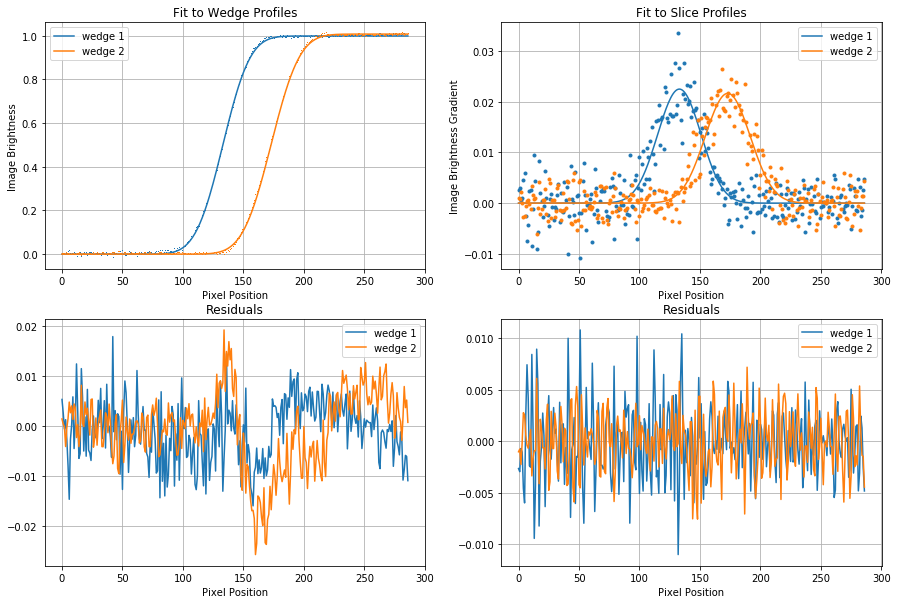

Wedge Angle  =  11.7 degrees
FWHM     (1) =  40 pixels, or 2.0 mm
FWHM     (2) =  42 pixels, or 2.1 mm
FWHM (GMEAN) =  41.0 pixels, or 2.1 mm


In [116]:
fit_1 = wedge_fn(xs_1, scale_1, centre_1, width_1, squareness_1)
fit_2 = wedge_fn(xs_2, scale_2, centre_2, width_2, squareness_2)

grad_profile_1 = np.gradient(profile_1)
grad_profile_2 = np.gradient(profile_2)

grad_fit_1 = np.gradient(fit_1)
grad_fit_2 = np.gradient(fit_2)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flat

axs[0].plot(profile_1, ',', color='C0')
axs[0].plot(fit_1, color='C0', label='wedge 1')
axs[0].plot(profile_2, ',', color='C1')
axs[0].plot(fit_2,  color='C1', label='wedge 2')
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('Fit to Wedge Profiles')
axs[0].set_xlabel('Pixel Position')
axs[0].set_ylabel('Image Brightness')

axs[1].plot(grad_profile_1, '.', color='C0')
axs[1].plot(grad_fit_1, color='C0', label='wedge 1')
axs[1].plot(grad_profile_2, '.', color='C1')
axs[1].plot(grad_fit_2,  color='C1', label='wedge 2')
axs[1].grid(True)
axs[1].legend()
axs[1].set_title('Fit to Slice Profiles')
axs[1].set_xlabel('Pixel Position')
axs[1].set_ylabel('Image Brightness Gradient')

axs[2].plot(fit_1 - profile_1, label='wedge 1')
axs[2].plot(fit_2 - profile_2, label='wedge 2')
axs[2].grid(True)
axs[2].legend()
axs[2].set_title('Residuals')
axs[2].set_xlabel('Pixel Position')

axs[3].plot(grad_fit_1 - grad_profile_1, label='wedge 1')
axs[3].plot(grad_fit_2 - grad_profile_2, label='wedge 2')
axs[3].grid(True)
axs[3].legend()
axs[3].set_title('Residuals')
axs[3].set_xlabel('Pixel Position')

plt.show()

inside_fit_1 = np.argwhere(grad_fit_1 > grad_fit_1.max() / 2)
fwhm_1_pixels = inside_fit_1[-1][0] - inside_fit_1[0][0]
inside_fit_2 = np.argwhere(grad_fit_2 > grad_fit_2.max() / 2)
fwhm_2_pixels = inside_fit_2[-1][0] - inside_fit_2[0][0]

# Calculate FWHM in mm taking account of pixel rescaling and plate projection angle
xspacing, yspacing = pix_dims

fwhm_gm_pixels = gmean([fwhm_1_pixels, fwhm_2_pixels])

fwhm_1_mm = fwhm_1_pixels * yspacing * np.tan(np.radians(wedge_angle))
fwhm_2_mm = fwhm_2_pixels * yspacing * np.tan(np.radians(wedge_angle))

fwhm_gm_mm = gmean([fwhm_1_mm, fwhm_2_mm])

print('Wedge Angle  = ', '%0.1f degrees' % wedge_angle)
print('FWHM     (1) = ', round(fwhm_1_pixels, 1),  'pixels, or', round(fwhm_1_mm, 1),  'mm')
print('FWHM     (2) = ', round(fwhm_2_pixels, 1),  'pixels, or', round(fwhm_2_mm, 1),  'mm')
print('FWHM (GMEAN) = ', round(fwhm_gm_pixels, 1), 'pixels, or', round(fwhm_gm_mm, 1), 'mm');

The fit doesn't look too bad though it clearly misses the very high points in the slice profile data. So this seems to confirm that the values for the slice thickness obtained using the edges really are quite a bit less than the values from the plates (pretty close to the nominal 3mm). Maybe the wedge angle is a bit different?